In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import os
import pathlib
import glob as glob

import hydra
from omegaconf import OmegaConf
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from cohlib.observations import sample_obs
from cohlib.utils import add0, jax_boilerplate, pickle_save, pickle_open

import cohlib.confs.utils as conf
from cohlib.confs.latent import create_lrccn_basic_rank1
from cohlib.confs.config import get_sim_config

In [61]:
# Get plots for previously saved data with large oscillations / high rate
app_res_path = '/projectnb/stephenlab/jtauber/cohlib/experiments/data/app/app_rat15/bottomK/latent-app_single_fullrank/window10000/K25/L50/obs-app_pp_log/mu-empirical/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl'
app_res_path_lr = '/projectnb/stephenlab/jtauber/cohlib/experiments/data/app/app_rat15/bottomK/latent-app_single_fullrank/window10000/K25/L50/obs-app_pp_log/mu-empirical/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-testing-factor-igprior/empirical-init/newton-10_em-20/res.pkl'
res = pickle_open(app_res_path)
res_lr = pickle_open(app_res_path_lr)

In [62]:
import jax.numpy as jnp
from typing import Any

def hermitize_from_upper(A: jnp.ndarray) -> jnp.ndarray:
    """
    Construct a Hermitian matrix by copying the conjugate-transpose of the
    upper-triangular part of `A` (excluding the diagonal) into the strictly
    lower-triangular part.

    Parameters
    ----------
    A : jnp.ndarray
        Square complex (or real) array of shape (N, N).

    Returns
    -------
    H : jnp.ndarray
        Hermitian array with H == H.conj().T.

    Raises
    ------
    ValueError
        If `A` is not a square matrix.

    Notes
    -----
    * Works with any JAX dtype that implements `.conj()`.
    * Does **not** modify `A` in-place; a new array is returned.
    * You can `jax.jit`-compile the function externally if desired.
    """
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError("Input must be a square matrix.")

    # Strict upper-triangle (k=1 excludes the diagonal)
    strict_upper = jnp.triu(A, k=1)

    # Diagonal preserved as-is
    diag = jnp.diag(jnp.diag(A))

    # Assemble Hermitian matrix:   H = diag + U + Uᴴ
    H = diag + strict_upper + strict_upper.conj().T
    return H


# --- Example --------------------------------------------------------------
if __name__ == "__main__":
    import jax

    A = jnp.array([[1+0j, 2+3j, 4-1j],
                   [7+5j, 5+0j, 6+2j],
                   [8-4j, 9+1j, 3+0j]])

    H = hermitize_from_upper(A)
    print("Hermitian matrix:\n", H)
    print("Is Hermitian?", jnp.allclose(H, H.conj().T))

    # Optional: JIT-compile for speed on repeated calls
    hermitize_jit = jax.jit(hermitize_from_upper)


Hermitian matrix:
 [[1.+0.j 2.+3.j 4.-1.j]
 [2.-3.j 5.+0.j 6.+2.j]
 [4.+1.j 6.-2.j 3.+0.j]]
Is Hermitian? True


In [63]:
from cohlib.utils import naive_estimator
from cohlib.latent import CCN
mseed = 42
mcM = 200
def get_pushforward_model_est_mc(res, mus, nz_model, freqs, num_mc_samples=mcM, mc_seed=mseed):
    cov = res['ccn_est'].gamma[0,:,:]
    K = cov.shape[0]
    cov_mod = hermitize_from_upper(cov)
    cov_mod = cov_mod.at[jnp.eye(K).astype(bool)].set(jnp.diag(cov_mod).real)
    dist = CCN(cov_mod[None,:,:], freqs, nz_model)

    rk = jr.key(mc_seed)
    zs_mc = dist.sample(rk, num_mc_samples)
    zs_0dc_mc = jnp.apply_along_axis(add0, 0, zs_mc)
    xs_mc = jnp.fft.irfft(zs_0dc_mc, axis=0)

    lams = jnp.exp(mus[None,:,None] + xs_mc)
    gamma_est_pushforward_mc = naive_estimator(lams, nz_model)

    return gamma_est_pushforward_mc

In [64]:
def omega(cfg):
    return OmegaConf.create(cfg)
cfg = omega(res['cfg'])
cfg.latent

{'latent_type': 'app_single_fullrank', 'num_freqs': 5000, 'target_freq_ind': 14, 'K': 25, 'L': 50}

In [65]:
from cohlib.utils import rotate_eigvecs
eigrank = 1
load_app_obs = conf.load_app_data(cfg)
obs = load_app_obs['obs']
lcfg = cfg.latent
nz_model = jnp.array([lcfg.target_freq_ind])
N = lcfg.num_freqs
freqs = jnp.arange(N)
ocfg = omega(res['cfg']['obs'])
obs_params, obs_type = conf.get_app_obs_params(ocfg, obs)
mus = obs_params['mu']
gamma_model_pushforward_mc = get_pushforward_model_est_mc(res, mus, nz_model, freqs)

eigvals_model = jnp.linalg.eigh(gamma_model_pushforward_mc)[0][::-1]
eigval_model = eigvals_model[eigrank-1]
eigvecs_model = jnp.linalg.eigh(gamma_model_pushforward_mc.squeeze())[1][:,::-1]
eigvec_model = rotate_eigvecs(eigvecs_model[None,:,:])[0,:,eigrank-1]

Loading App Data
Experiment Type: bottomK


In [66]:
gamma_model_lr_pushforward_mc = get_pushforward_model_est_mc(res_lr, mus, nz_model, freqs)

eigvals_model_lr = jnp.linalg.eigh(gamma_model_lr_pushforward_mc)[0][::-1]
eigval_model_lr = eigvals_model_lr[eigrank-1]
eigvecs_model_lr = jnp.linalg.eigh(gamma_model_lr_pushforward_mc.squeeze())[1][:,::-1]
eigvec_model_lr = rotate_eigvecs(eigvecs_model_lr[None,:,:])[0,:,eigrank-1]


In [67]:
eigvals_model_lr.squeeze()

Array([8.2909778e+02, 1.0926852e+03, 1.6041869e+03, 1.8861866e+03,
       2.5901506e+03, 2.7895317e+03, 3.4821531e+03, 5.5513545e+03,
       6.4933628e+03, 6.7822246e+03, 8.2563916e+03, 9.5748779e+03,
       1.2155118e+04, 1.3373146e+04, 1.7777131e+04, 2.0688949e+04,
       2.3424902e+04, 3.0741297e+04, 3.3880469e+04, 4.5057438e+04,
       4.0774422e+05, 9.6614869e+05, 1.6742579e+06, 6.8725080e+06,
       8.5564650e+06], dtype=float32)

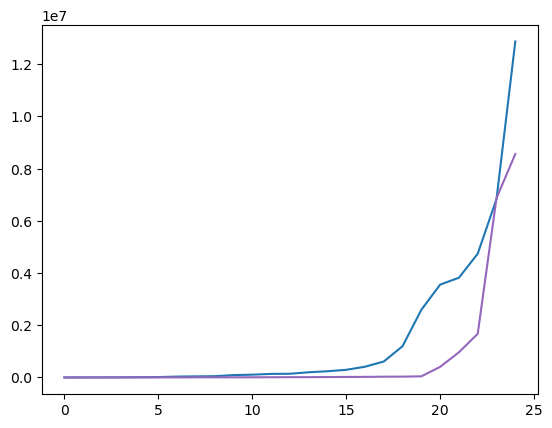

In [68]:
plt.plot(eigvals_model.squeeze(), color='tab:blue')
plt.plot(eigvals_model_lr.squeeze(), color='tab:purple')
# plt.ylim([0,1e8])

In [69]:
eigvecs_model.shape

(25, 25)

In [70]:
load_app_obs = conf.load_app_data(cfg)
obs = load_app_obs['obs']

Loading App Data
Experiment Type: bottomK


In [46]:
ocfg = omega(res['cfg']['obs'])
obs_params, obs_type = conf.get_app_obs_params(ocfg, obs)
obs_params['mu']

Array([-0.78965807, -0.8439701 , -0.90140206, -0.9571127 , -0.99425226,
       -1.0272224 , -1.0906441 , -1.1270118 , -1.1776555 , -1.2378744 ,
       -1.3019532 , -1.3783262 , -1.4105871 , -1.4610178 , -1.5994877 ,
       -1.609438  , -1.6928196 , -1.7372713 , -1.9951004 , -2.0557249 ,
       -2.0557249 , -2.244316  , -2.3025851 , -2.453408  , -2.6036901 ],      dtype=float32)

In [47]:
eigrank = 1
jind_nz = 0

# TODO fix for 
nz_model = cfg.latent.target_freq_ind

naive_est = naive_estimator(obs, nz_model)*1e6

In [48]:
evals_model, evecs_model = jnp.linalg.eigh(res['ccn_est'].gamma.squeeze())
evals_naive, evecs_naive = jnp.linalg.eigh(naive_est)

In [49]:
evecs_model.shape

(25, 25)

In [50]:
thetas_model = jnp.angle(evecs_model[0,:])
rotations_model = jnp.exp(-1j*thetas_model)
rotated_model = evecs_model * rotations_model[None,:]

In [51]:
thetas_model = jnp.angle(eigvecs_model[0,:])
rotations_model = jnp.exp(-1j*thetas_model)
rotated_model = eigvecs_model * rotations_model[None,:]

In [52]:
thetas_naive = jnp.angle(evecs_naive[0,:])
rotations_naive = jnp.exp(-1j*thetas_naive)
rotated_naive = evecs_naive * rotations_naive[None,:]

In [53]:
save_path = '/projectnb/stephenlab/jtauber/cohlib/experiments/lr_figures/temp'

In [56]:
eigvec_model_lr

Array([ 0.5508482 +4.8156679e-08j,  0.03842293+9.9360682e-02j,
       -0.5219376 -1.1832644e-01j, -0.21645492-1.3722951e-02j,
        0.14021038+1.0818241e-01j,  0.22160037+2.0562407e-01j,
        0.03811511+3.9865084e-02j,  0.00814964-8.3556054e-03j,
        0.09439594+4.8307430e-02j,  0.13663925+5.5350170e-02j,
        0.15039346+2.6080224e-01j,  0.11852376+1.2272032e-01j,
        0.09072683-8.7335967e-02j, -0.0024455 +1.1401019e-01j,
       -0.02537654+4.0301025e-02j,  0.07551329+1.3961488e-01j,
        0.00902267+6.2968671e-02j, -0.0504507 +2.4694590e-02j,
       -0.03494316+7.3934026e-02j, -0.01158209+8.6801359e-03j,
       -0.03313761+5.8928863e-03j, -0.00870398-2.4638684e-02j,
       -0.00127349+2.0930765e-02j,  0.00185666+2.0065654e-02j,
       -0.00439639-1.1125187e-05j], dtype=complex64)

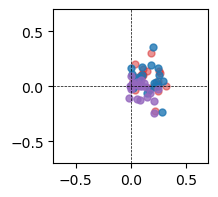

In [71]:
lim = 0.7
fig, ax = plt.subplots(figsize=(2,2))
ax.plot(rotated_naive[:,-1].real, rotated_naive[:,-1].imag, '.', markersize=10,  color='tab:red', alpha=0.5, label='naive')
# ax.plot(rotated_model[:,-1].real, rotated_model[:,-1].imag, '.', markersize=10,  color='tab:blue', alpha=0.8, label='model')
ax.plot(eigvec_model.real, eigvec_model.imag, '.', markersize=10,  color='tab:blue', alpha=0.8, label='model')
ax.plot(eigvec_model_lr.real, eigvec_model_lr.imag, '.', markersize=10,  color='tab:purple', alpha=0.8, label='model-lr')
ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax.axvline(0, color='k', linestyle='--', linewidth=0.5)
ax.set_xlim([-lim,lim])
ax.set_ylim([-lim,lim])
# plt.legend()

save_name = os.path.join(save_path, '4evec_low.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")


In [26]:
eigvals_model.shape

(1, 25)

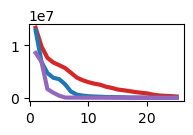

In [72]:
K = 25
x = jnp.arange(K) + 1
fig, ax = plt.subplots(figsize=(2,1))
mw = 3
evs_model, _ = jnp.linalg.eigh(res['ccn_est'].gamma)
evs_naive, _ = jnp.linalg.eigh(naive_est)
ax.plot(x, evs_naive.squeeze()[::-1], color='tab:red', linewidth=mw, label = 'naive')
ax.plot(x, eigvals_model.squeeze()[::-1], color='tab:blue', linewidth=mw, label='model')
ax.plot(x, eigvals_model_lr.squeeze()[::-1], color='tab:purple', linewidth=mw, label='model-lr')
# ax.plot(x, func(true_dummy)/K, color='k', linewidth=mw, label='true') ax.plot(x, func(jnp.stack(plot_dict['naive'])).mean(0)/K, linewidth=mw, color='tab:red', label='naive')
# ax.fill_between(x, naive_low, naive_high, color='tab:red', alpha=0.3)
# ax.plot(x, func(jnp.stack(plot_dict['model'])).mean(0)/K, linewidth=mw, color='tab:blue', label='model')
# ax.fill_between(x, model_low, model_high, color='tab:blue', alpha=0.3)
# ax.plot(x, func(jnp.stack(plot_dict['oracle'])).mean(0)/K,  linewidth=mw, color='tab:green', linestyle='--', label='oracle')
# ax.fill_between(x, oracle_low, oracle_high, color='tab:green', alpha=0.3)
# ax.set_ylabel(r'$\hat{\lambda}/K$')
# ax.set_xlabel('Eigenvalue Index')
# ax.set_ylim([0,80000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# ax.set_title(r'$\mu_{e}$=2.5' + ' spikes/sec; L = 25')
# ax.set_title(r'$\mu$=2.5' + ' spikes/sec; L = 25$')
# plt.legend(fontsize=8)
# ax.set_xlim(0,5)

save_name = os.path.join(save_path, '4evals_low.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")



In [73]:
print(eigvals_model_lr.squeeze()[-1] / eigvals_model_lr.squeeze().sum())
print(eigvals_model.squeeze()[-1] / eigvals_model.squeeze().sum())
print(evs_naive.squeeze()[-1] / evs_naive.squeeze().sum())

0.45695028
0.33838928
0.16161384


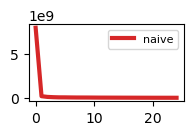

In [58]:
K = 20
x = jnp.arange(K) + 1
fig, ax = plt.subplots(figsize=(2,1))
mw = 3
evs_model, _ = jnp.linalg.eigh(res['ccn_est'].gamma)
evs_naive, _ = jnp.linalg.eigh(naive_est)
ax.plot(evs_naive.squeeze()[::-1], color='tab:red', linewidth=mw, label = 'naive')
# ax.plot(evs_model.squeeze()[::-1], color='tab:blue', linewidth=mw, label='model')
# ax.plot(x, func(true_dummy)/K, color='k', linewidth=mw, label='true') ax.plot(x, func(jnp.stack(plot_dict['naive'])).mean(0)/K, linewidth=mw, color='tab:red', label='naive')
# ax.fill_between(x, naive_low, naive_high, color='tab:red', alpha=0.3)
# ax.plot(x, func(jnp.stack(plot_dict['model'])).mean(0)/K, linewidth=mw, color='tab:blue', label='model')
# ax.fill_between(x, model_low, model_high, color='tab:blue', alpha=0.3)
# ax.plot(x, func(jnp.stack(plot_dict['oracle'])).mean(0)/K,  linewidth=mw, color='tab:green', linestyle='--', label='oracle')
# ax.fill_between(x, oracle_low, oracle_high, color='tab:green', alpha=0.3)
# ax.set_ylabel(r'$\hat{\lambda}/K$')
# ax.set_xlabel('Eigenvalue Index')
# ax.set_ylim([0,80000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# ax.set_title(r'$\mu_{e}$=2.5' + ' spikes/sec; L = 25')
# ax.set_title(r'$\mu$=2.5' + ' spikes/sec; L = 25$')
plt.legend(fontsize=8)
# ax.set_xlim(0,5)


In [ ]:
fig
evs_model, _ = jnp.linalg.eigh(res['ccn_est'].gamma)
evs_naive, _ = jnp.linalg.eigh(naive_est)
ax.plot(evs_model.squeeze()[::-1])
ax.plot(evs_naive.squeeze()[::-1])

In [21]:
def plot_eigval_var_L_subplot(ax, plot_dict, drop_emp):
    naive_color = 'tab:red'
    naive_style = 'dashed'
    naive_width = 2

    true_color = 'k'
    true_style = 'solid'
    true_width = 2

    oracle_color = 'tab:green'
    oracle_style = 'dotted'
    oracle_width = 2.5

    est_color = 'tab:blue'
    est_style = 'solid'
    est_width = 2

    ev_true = plot_dict['eigval_true']
    ev_oracle = plot_dict['eigval_oracle']
    ev_naive = plot_dict['eigval_naive']
    evs_em = plot_dict['eigvals_em']

    ax.axhline(ev_true, linestyle=true_style, color=true_color, linewidth=true_width)
    ax.axhline(ev_oracle, linestyle=oracle_style, color=oracle_color, linewidth=oracle_width)
    if drop_emp is False:
        ax.axhline(ev_naive, linestyle=naive_style, color=naive_color, linewidth=naive_width)
    ax.plot(evs_em, color=est_color, linestyle=est_style, linewidth=est_width)

def get_theta_label(ocfg, theta):
    if ocfg.obs_type == 'gaussian':
        label = f'{ocfg.ov1}e{theta}'
    elif ocfg.obs_type in ['pp_relu', 'pp_log']:
        label = f'mu = {theta}'
    else:
        return ValueError
    return label

def get_ccn_fullrank_eigvals(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    eigvals_raw, _ = jnp.linalg.eigh(gamma)
    eigvals = eigvals_raw[:,::-1]
    return eigvals

In [59]:
from cohlib.utils import rotate_eigvecs, naive_estimator
from cohlib.plot import get_eigval
eigrank = 1
eigvals_em = jnp.stack([get_ccn_fullrank_eigvals(x)[0,eigrank-1] for x in res['track']['ccn']])

# load zs data and compute oracle est
jind_nz = 0

# TODO fix for 
nz_model = cfg.latent.target_freq_ind

naive_est = naive_estimator(obs, nz_model)*1e6
naive_eigval = get_eigval(naive_est[:,:], eigrank)

In [60]:
res['ccn_est']

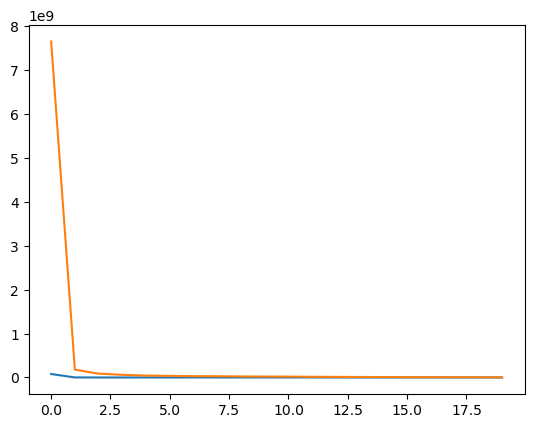

In [22]:
evs_model, _ = jnp.linalg.eigh(res['ccn_est'].gamma)
evs_naive, _ = jnp.linalg.eigh(naive_est)
plt.plot(evs_model.squeeze()[::-1])
plt.plot(evs_naive.squeeze()[::-1])

In [ ]:
from cohlib.utils import rotate_eigvecs, naive_estimator
from cohlib.plot import get_eigval
eigrank = 1
eigvals_em = jnp.stack([get_ccn_fullrank_eigvals(x)[0,eigrank-1] for x in res['track']['ccn']])

# load zs data and compute oracle est
jind_nz = 0

# TODO fix for 
nz_model = cfg.latent.target_freq_ind

naive_est = naive_estimator(obs, nz_model)*1e6
naive_eigval = get_eigval(naive_est[:,:], eigrank)

In [62]:
evs_model.squeeze()[-1] / evs_model.sum()
# evs_naive.squeeze()[-1] / evs_naive.sum()

Array(0.98464453, dtype=float32)

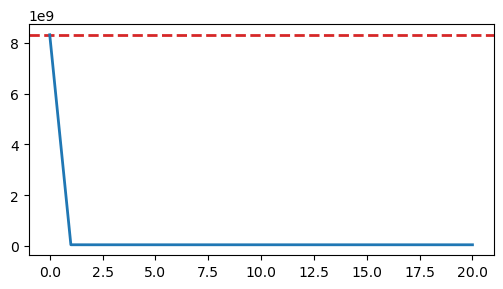

In [63]:
drop_emp = False
naive_color = 'tab:red'
naive_style = 'dashed'
naive_width = 2

est_color = 'tab:blue'
est_style = 'solid'
est_width = 2

# ev_true = plot_dict['eigval_true']
# ev_oracle = plot_dict['eigval_oracle']
# ev_naive = plot_dict['eigval_naive']
# evs_em = plot_dict['eigvals_em']

fig, ax = plt.subplots(figsize=(6,3))
if drop_emp is False:
    ax.axhline(naive_eigval, linestyle=naive_style, color=naive_color, linewidth=naive_width)
ax.plot(eigvals_em, color=est_color, linestyle=est_style, linewidth=est_width)

In [64]:
jnp

<module 'jax.numpy' from '/projectnb/stephenlab/jtauber/.conda/envs/sgc_env/lib/python3.10/site-packages/jax/numpy/__init__.py'>

In [ ]:
def get_ccn_fullrank_eigvecs(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    _, eigvecs_raw = jnp.linalg.eigh(gamma)
    eigvecs = eigvecs_raw[:,:,::-1]
    return eigvecs

In [72]:
def get_ccn_fullrank_eigvecs(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    _, eigvecs_raw = jnp.linalg.eigh(gamma)
    eigvecs = eigvecs_raw[:,:,::-1]
    return eigvecs

In [73]:
eigvecs_em = jnp.stack([rotate_eigvecs(get_ccn_fullrank_eigvecs(x))[0,:,eigrank-1] for x in res['track']['ccn']])

(21, 10)

In [65]:
evs_model, _  = jnp.linalg.eigh(res['ccn_est'].gamma)
evs_naive, _ = jnp.linalg.eigh(naive_est)

In [66]:
evs_model, evecs_model = jnp.linalg.eigh(res['ccn_est'].gamma)
evs_naive, evecs_naive = jnp.linalg.eigh(naive_est)

In [78]:
x = res['ccn_est']
evecs_model2 = rotate_eigvecs(get_ccn_fullrank_eigvecs(x))[0,:,eigrank-1]

In [70]:
evecs_model[:,-1]

Array([[ 0.08226892+0.03559953j,  0.05420819+0.00459078j,
         0.01740329+0.14748599j,  0.01824215-0.17548418j,
         0.04005831-0.01652051j, -0.24272335-0.3017471j ,
        -0.26468632-0.14176641j, -0.09276522+0.2921133j ,
         0.6803575 +0.26561007j,  0.25166693+0.05581713j]],      dtype=complex64)

In [82]:
from cohlib.plot import get_eigvec
naive_eigvec = get_eigvec(naive_est, eigrank)
naive_eigvec = naive_eigvec*jnp.exp(-1j*jnp.angle(naive_eigvec[0]))

In [83]:
naive_eigvec

Array([0.55281043+0.j        , 0.42898875-0.029037j  ,
       0.28245026+0.04205109j, 0.37714002+0.00741504j,
       0.2786646 +0.02137076j, 0.2514924 +0.00962131j,
       0.23314461+0.02575278j, 0.20338036-0.01104157j,
       0.17168188+0.02786134j, 0.12917876+0.02819744j], dtype=complex64)

(-1.0, 1.0)

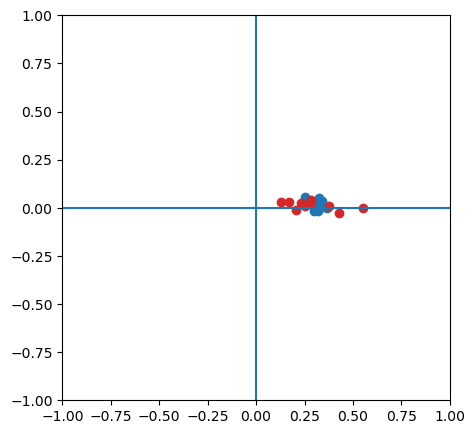

In [84]:

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(evecs_model2.real, evecs_model2.imag, color='tab:blue')
ax.scatter(naive_eigvec.real, naive_eigvec.imag, color='tab:red')
ax.axhline(0)
ax.axvline(0)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

In [ ]:
# plot ev eigvecs

In [26]:
plt.plot(eigvals_em)

Array([8.3148247e+09, 5.0653648e+07, 4.9775892e+07, 4.9831884e+07,
       4.9869508e+07, 4.9890004e+07, 4.9902384e+07, 4.9910452e+07,
       4.9916024e+07, 4.9920044e+07, 4.9923040e+07, 4.9925316e+07,
       4.9927116e+07, 4.9928556e+07, 4.9929712e+07, 4.9930680e+07,
       4.9931480e+07, 4.9932124e+07, 4.9932672e+07, 4.9933184e+07,
       4.9933576e+07], dtype=float32)

In [23]:
naive_est.shape

(10, 10)